In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.envs.darkroom import DarkroomEnv

# Load Model

In [88]:
corr = 0.25
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "darkroom_simple")


epoch=13-val_loss=0.911523.ckpt


In [89]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))
maze_dim = int(re.search(r'_dim(\d+)_corr', eval_dset_path).group(1))
node_encoding_corr = float(re.search(r'corr(\d*\.?\d*)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": state_dim,
    "action_dim": 5,
    "dropout": dropout,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
}

In [90]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

/tmp/ipykernel_934438/4170590101.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [91]:
n_eval_envs = 50

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


In [116]:
i_eval = 11
traj = eval_trajs[i_eval]

In [117]:
env_config = {
    'maze_dim': maze_dim,
    'horizon': 200,
    'state_dim': state_dim,
    'node_encoding_corr': node_encoding_corr,
    'initialization_seed': np.array(traj['initialization_seed']).item(),
    'goal': np.array(traj['goal'])
}
env = DarkroomEnv(**env_config)


# Run Model

In [118]:
max_seq_length = 250

In [119]:
xs = []
ys = []
state_features = []
state_features = list(env.node_map_encoding_to_pos.keys())

for state_feature in state_features:
    xs.append(env.node_map_encoding_to_pos[state_feature][0])
    ys.append(env.node_map_encoding_to_pos[state_feature][1])

reward_idx = np.argwhere([np.all(s == env.goal) for s in state_features]).item() 

In [120]:
def run_model(traj, model, state_features, seq_length, zero_reward=False):
    hidden_states = [[] for _ in range(model.n_layer)]
    
    for state_feature in state_features: 
        batch = {
            'context_states': convert_to_tensor([np.array(traj['context_states'])]),
            'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
            'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
            'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
            'query_states': convert_to_tensor([np.array(state_feature)]),
            }
        batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
        for k in batch.keys():
            if 'context' in k:
                batch[k] = batch[k][:,:seq_length]
            batch[k] = batch[k].to(model.device)
        model.save_activations = True
        if zero_reward:
            batch['context_rewards'] *= 0
        with torch.no_grad():
            out = model(batch)
        _hidden_states = model.activations['hidden_states'][1:] # Tuple over layers
        for i_layer in range(model.n_layer):
            hidden_states[i_layer].append(_hidden_states[i_layer])
    return hidden_states

In [121]:
true_dist_matrix = []

for state_feature in state_features:
    _, dist_from_state = env._make_opt_action_dict(state_feature)
    sorted_dist_from_state = []
    for state_feature in state_features:
        sorted_dist_from_state.append(dist_from_state[state_feature])
    true_dist_matrix.append(sorted_dist_from_state)

true_dist_matrix = np.array(true_dist_matrix)
gamma = 0.8
K_input = gamma ** true_dist_matrix # exponential kernel


In [122]:
def get_kernel_alignment(K_A, K_B):
    """ Centered Kernel Alignment """
    n = K_A.shape[0]
    I = np.eye(n)
    H = I - np.ones((n, n)) / n
    K_A_centered = H @ K_A @ H
    K_B_centered = H @ K_B @ H
    
    # Compute alignment using Frobenius norm
    numerator = np.sum(K_A_centered * K_B_centered)
    denominator = np.sqrt(np.sum(K_A_centered * K_A_centered) * np.sum(K_B_centered * K_B_centered))
    
    return numerator / denominator if denominator != 0 else 0

In [123]:
dist_func = lambda data: squareform(pdist(data, metric='correlation'))
#dist_func = lambda data: squareform(pdist(data))

def get_dist_metric(hidden_states, true_dist_matrix, random_ctrl=False):
    kas = []
    dist_matrices = []
    for layer in range(len(hidden_states)):
        X = torch.stack(hidden_states[layer])
        X = X.detach().cpu().numpy().squeeze()  # (states, sequence length, hidden dim)
        data = X[:, -1, :]  # Response when given last (query) token
        if random_ctrl:
            data = data[np.random.permutation(len(data))]

        representation_dist_matrix = dist_func(data)
        clip_val = np.percentile(representation_dist_matrix, 99)
        representation_dist_matrix = np.clip(representation_dist_matrix, None, clip_val)
        representation_dist_matrix = representation_dist_matrix / representation_dist_matrix.max()

        data -= data.mean(0)[None,:]
        K_latents = data @ data.T
        kernel_alignment = get_kernel_alignment(K_input, K_latents)
        kas.append(kernel_alignment)
        dist_matrices.append(representation_dist_matrix)
    return kas, dist_matrices

In [124]:
quadrants = []
for x, y in zip(xs, ys):
    if x < maze_dim//2:
        if y < maze_dim//2:
            quadrants.append(0)
        else:
            quadrants.append(1)
    else:
        if y < maze_dim//2:
            quadrants.append(3)
        else:
            quadrants.append(2)

In [138]:
def make_pca_plots(hidden_states, dims=[0,1], figname=None):
    n_layers = len(hidden_states)
    fig, axs = plt.subplots(1, n_layers, figsize=(2.5, 0.9))
    
    # Create a dictionary mapping (x,y) to PCA coordinates for connecting neighbors
    for layer in range(n_layers):
        X = torch.stack(hidden_states[layer])
        X = X.detach().cpu().numpy().squeeze()
        data = X[:, -1, :]
        
        # Perform PCA
        pca = PCA(n_components=10)
        data_pca = pca.fit_transform(data)
        data_pca = data_pca / np.abs(data_pca).max(axis=0)
        
        # Create mapping of maze positions to PCA coordinates
        pos_to_pca = {(x, y): data_pca[i] for i, (x, y) in enumerate(zip(xs, ys))}
        
        # Plot connections first (so they appear behind points)
        for i, (x, y) in enumerate(zip(xs, ys)):
            # Connect to right neighbor
            if (x + 1, y) in pos_to_pca:
                axs[layer].plot([data_pca[i][dims[0]], pos_to_pca[(x + 1, y)][0]],
                              [data_pca[i][dims[1]], pos_to_pca[(x + 1, y)][1]],
                              'gray', alpha=0.3, linewidth=1.)
            # Connect to upper neighbor
            if (x, y + 1) in pos_to_pca:
                axs[layer].plot([data_pca[i][dims[0]], pos_to_pca[(x, y + 1)][0]],
                              [data_pca[i][dims[1]], pos_to_pca[(x, y + 1)][1]],
                              'gray', alpha=0.3, linewidth=1.)
        
        # Plot the points
        pt_mask = np.ones(len(data_pca), dtype=bool)
        pt_mask[reward_idx] = False

        # Single color mapping
        _xs = np.array(xs)
        _ys = np.array(ys)
        position_values = np.array(_xs + _ys*5)
        axs[layer].scatter(
            data_pca[pt_mask, dims[0]], data_pca[pt_mask, dims[1]],
            c=position_values[pt_mask], s=5,
            cmap='plasma',
            alpha=1.)        

        axs[layer].scatter(
            data_pca[reward_idx, dims[0]], data_pca[reward_idx, dims[1]],
            c='red', s=15,
            alpha=1., marker='*')
        
        axs[layer].set_aspect('equal', 'box')
        axs[layer].set_box_aspect(1)
        axs[layer].set_xticks([])
        axs[layer].set_yticks([])
        for spine in axs[layer].spines.values():
            spine.set_visible(True)
    
    plt.tight_layout(pad=0.2, w_pad=0.5)
    if figname is not None:
        plt.savefig('figs/' + figname + '.png', transparent=True, dpi=300)
        plt.savefig('figs/' + figname + '.svg', transparent=True, dpi=300)
    plt.show()

Sequence Length: 1


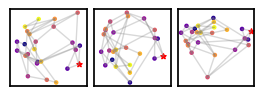

Sequence Length: 250


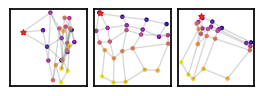

In [139]:
dist_results = {
   'seq_length': [],
   'layer': [],
   'diff': [], 
   'random_diff': [],
   'diff_no_reward': []
}
seq_lengths = [1, max_seq_length]
for seq_length in seq_lengths:
    print(f'Sequence Length: {seq_length}')
    hidden_states = run_model(traj, model, state_features, seq_length)
    diffs, dist_matrices = get_dist_metric(hidden_states, true_dist_matrix)
    random_diffs, _ = get_dist_metric(hidden_states, true_dist_matrix, random_ctrl=True)
    hidden_states_no_reward = run_model(traj, model, state_features, seq_length, zero_reward=True)
    diffs_no_reward, _ = get_dist_metric(hidden_states_no_reward, true_dist_matrix)
    figname = '3a' if seq_length == 1 else '3b'
    make_pca_plots(hidden_states_no_reward, figname=figname)
    dist_results['seq_length'].extend([seq_length] * model.n_layer)
    dist_results['layer'].extend(range(model.n_layer))
    dist_results['diff'].extend(diffs)
    dist_results['random_diff'].extend(random_diffs)
    dist_results['diff_no_reward'].extend(diffs_no_reward)
    # Clear GPU memory
    del hidden_states
    torch.cuda.empty_cache()


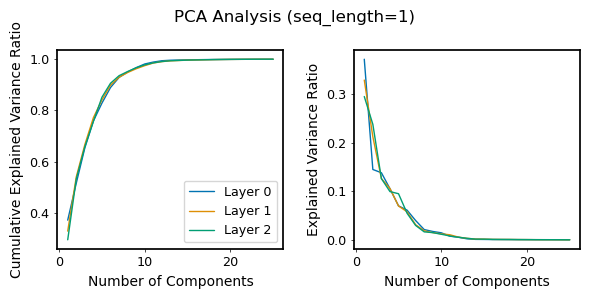

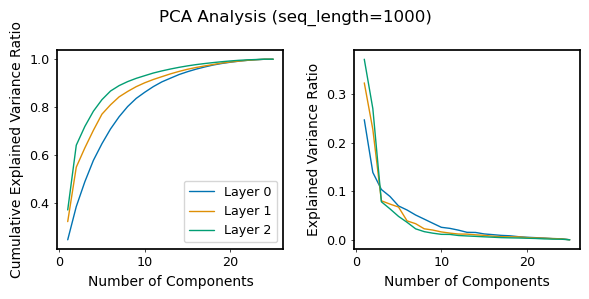

In [127]:
def plot_explained_variance(hidden_states, seq_length):
    n_layers = len(hidden_states)
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    
    for layer in range(n_layers):
        X = torch.stack(hidden_states[layer])
        X = X.detach().cpu().numpy().squeeze()  # (states, sequence length, hidden dim)
        data = X[:, -1, :]  # Response when given last (query) token
        
        # Perform PCA
        pca = PCA()
        pca.fit(data)
        
        # Calculate cumulative explained variance ratio
        cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
        
        # Plot
        axs[0].plot(range(1, len(cumulative_variance_ratio) + 1), 
                    cumulative_variance_ratio,
                    label=f'Layer {layer}')
        axs[1].plot(range(1, len(pca.explained_variance_ratio_) + 1),
                    pca.explained_variance_ratio_,
                    label=f'Layer {layer}')
    
    for ax in axs:
        ax.set_xlabel('Number of Components')
        ax.grid(True)
    
    axs[0].set_ylabel('Cumulative Explained Variance Ratio')
    axs[1].set_ylabel('Explained Variance Ratio')
    axs[0].legend()
    plt.suptitle(f'PCA Analysis (seq_length={seq_length})')
    plt.tight_layout()
    plt.show()

# Plot for seq_length = 1
hidden_states_1 = run_model(traj, model, state_features, seq_length=1)
plot_explained_variance(hidden_states_1, seq_length=1)
del hidden_states_1
torch.cuda.empty_cache()

# Plot for seq_length = 1000
hidden_states_1000 = run_model(traj, model, state_features, seq_length=1000)
plot_explained_variance(hidden_states_1000, seq_length=1000)
del hidden_states_1000
torch.cuda.empty_cache()

In [33]:
dist_results = {
   'seq_length': [],
   'layer': [],
   'diff': [], 
   'random_diff': [],
   'diff_no_reward': []
}

seq_lengths = np.arange(0, max_seq_length, 10)
seq_lengths[0] = 1
for seq_length in seq_lengths:
    hidden_states = run_model(traj, model, state_features, seq_length)
    diffs, dist_matrices = get_dist_metric(hidden_states, true_dist_matrix)
    random_diffs, _ = get_dist_metric(hidden_states, true_dist_matrix, random_ctrl=True)
    hidden_states_no_reward = run_model(traj, model, state_features, seq_length, zero_reward=True)
    diffs_no_reward, _ = get_dist_metric(hidden_states_no_reward, true_dist_matrix)
    dist_results['seq_length'].extend([seq_length] * model.n_layer)
    dist_results['layer'].extend(range(model.n_layer))
    dist_results['diff'].extend(diffs)
    dist_results['random_diff'].extend(random_diffs)
    dist_results['diff_no_reward'].extend(diffs_no_reward)
    # Clear GPU memory
    del hidden_states
    torch.cuda.empty_cache()

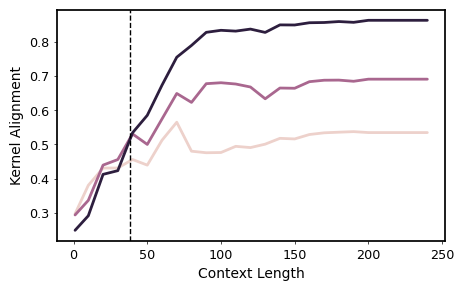

In [34]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(
    data=dist_results, x='seq_length', y='diff', hue='layer',
    linewidth=2,
    ax=ax, legend=False)
ax.set_xlabel('Context Length')
ax.set_ylabel('Kernel Alignment')
first_reward = np.argwhere(np.array(traj['context_rewards'])>0)
if first_reward.size > 0:
    ax.axvline(x=first_reward[0], color='black', linestyle='--')
plt.show()

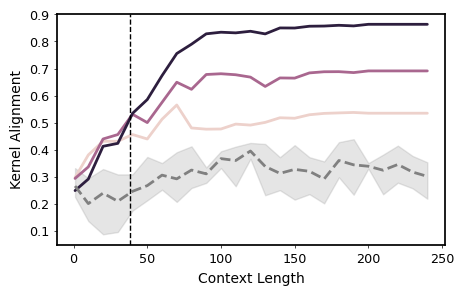

In [35]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(
    data=dist_results, x='seq_length', y='diff', hue='layer',
    linewidth=2,
    ax=ax, legend=False)
sns.lineplot(
    data=dist_results, x='seq_length', y='random_diff',
    linewidth=2, linestyle='--', color='gray',
    ax=ax, legend=False)
ax.set_xlabel('Context Length')
ax.set_ylabel('Kernel Alignment')
first_reward = np.argwhere(np.array(traj['context_rewards'])>0)
if first_reward.size > 0:
    ax.axvline(x=first_reward[0], color='black', linestyle='--')
plt.show()